In [295]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import special
from scipy import integrate

In [616]:
time = 4.0*np.pi # total time in seconds
dt=0.1 # Timestep
nt = int(time / dt) # number of time steps
t0=0; theta0=np.pi*0.05; u0 = 0 #Initial time, theta, u

order = 2 # order of symplectic integrator

g = 10 # define g for energy analysis

t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

# position update function
def f(theta,u,t):
    return u
   
# velocity update function
def g(theta,u,t):
    k = 1.0
    gamma = 0.1 # strengh of driving force
    w = 1.0 # frequency of driving force
    B = 0 # damping constant
    return (gamma*np.cos(w*t) - 2*B*u - np.sin(theta))*k**2


In [617]:
# Euler's method (1st order symplectic)
def euler(t,dt,theta0,u0):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    u[0] = u0
    
    for i in range(nt-1):
        u[i+1] = u[i] + dt*g(theta[i],u[i],t[i])
        theta[i+1] = theta[i] + dt*f(theta[i],u[i+1],t[i+1]) # Semi-implicit Euler's method
        
    return [theta,u]

# Symplectic integrator
def symplectic(t,dt,theta0,u0,order):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    u[0] = u0
        
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
    for i in range(nt-1):
        u[i+1] = u[i] + d[0]*dt*g(theta[i],u[i],t[i])
        theta[i+1] = theta[i] + c[0]*dt*f(theta[i],u[i+1],t[i+1])
        
        u[i+1] = u[i+1] + d[1]*dt*g(theta[i+1],u[i+1],t[i+1])
        theta[i+1] = theta[i+1] + c[1]*dt*f(theta[i+1],u[i+1],t[i+1])
        
        u[i+1] = u[i+1] + d[2]*dt*g(theta[i+1],u[i+1],t[i+1])
        theta[i+1] = theta[i+1] + c[2]*dt*f(theta[i+1],u[i+1],t[i+1])
        
        u[i+1] = u[i+1] + d[3]*dt*g(theta[i+1],u[i+1],t[i+1])
        theta[i+1] = theta[i+1] + c[3]*dt*f(theta[i+1],u[i+1],t[i+1])
        
    return [theta,u]

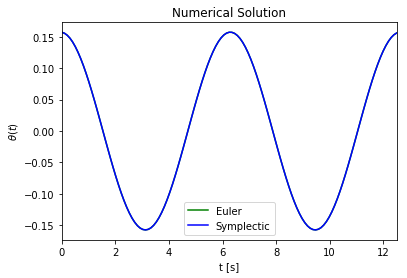

In [618]:
# Solve and plot results

thetaSym,uSym = symplectic(t,dt,theta0,u0,order)
thetaEuler,uEuler = euler(t,dt,theta0,u0)

plt.plot(t,thetaEuler,label="Euler",color="g")
plt.plot(t,thetaSym,label="Symplectic",color="b")
plt.xlabel('t [s]')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.legend()
plt.title("Numerical Solution")
plt.show()

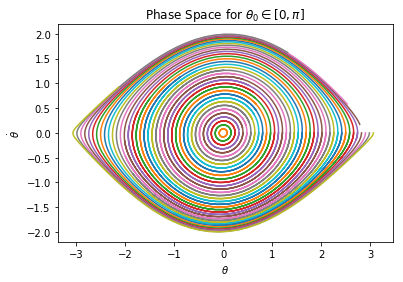

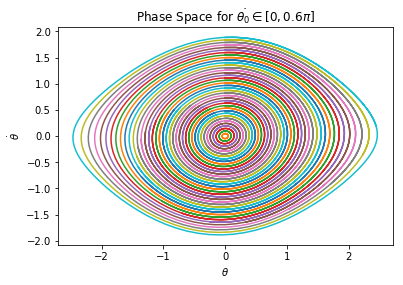

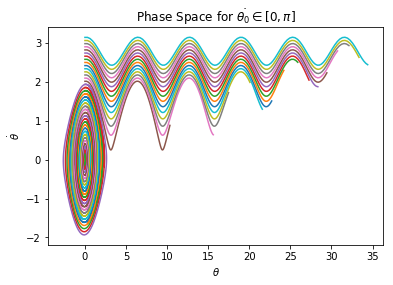

In [620]:
# Phase space plots
nth = 40 # number of values to run

# Vary theta
theta0s = np.linspace(0,1,nth)*np.pi
u0s = np.zeros(nth)
for i in range(nth):
    thetas,us = symplectic(t,dt,theta0s[i],u0s[i],order)
    plt.plot(thetas,us)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'Phase Space for $\theta_{0} \in [0,\pi]$')
plt.savefig("figures/phaseSpace.png")
plt.show()

# Vary theta_dot
theta0s = np.zeros(nth)
u0s = np.linspace(0,0.6,nth)*np.pi

for i in range(nth):
    thetas,us = symplectic(t,dt,theta0s[i],u0s[i],order)
    plt.plot(thetas,us)
   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'Phase Space for $\dot{\theta_{0}} \in [0,0.6\pi]$')
plt.savefig("figures/phaseSpaceDot.png")
plt.show()

theta0s = np.zeros(nth)
u0s = np.linspace(0,1,nth)*np.pi

for i in range(nth):
    thetas,us = symplectic(t,dt,theta0s[i],u0s[i],order)
    plt.plot(thetas,us)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'Phase Space for $\dot{\theta_{0}} \in [0,\pi]$')
plt.savefig("figures/phaseSpaceDot2.png")
plt.show()